In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from core.utils_ipynb import read_exp_result_files

%matplotlib inline
import torch
import matplotlib.pyplot as plt
import networkx as nx
from colour import Color
from torch_geometric.data import Batch
from grave import plot_network
from core.train_engine import dataset_factory
from core.utils import my_collate

In [73]:
result_dir = './results'
results = read_exp_result_files(result_dir)

dataset_name = 'IMDB-BINARY'
dataset = dataset_factory(dataset_name, verbose=False)

results = [r for r in results if r['exp_cfg']['model']['model_type'] == 'PershomLearnedFilt']
results = [r for r in results if r['exp_cfg']['model']['use_node_degree']]
if dataset.num_node_lab is not None:
    results = [r for r in results if r['exp_cfg']['model']['use_node_label']]
results = [r for r in results if r['exp_cfg']['model']['gin_number'] == 1]
results = [r for r in results if r['exp_cfg']['model']['gin_dimension'] == 64]
results = [r for r in results if r['exp_cfg']['dataset_name'] == dataset_name]
results = [r for r in results if r['exp_cfg']['training']['batch_size'] == 32]
print(len(results))
for r in results:
    print(r['exp_cfg'])

1
{'dataset_name': 'IMDB-BINARY', 'training': {'lr': 0.01, 'lr_drop_fact': 0.5, 'num_epochs': 100, 'epoch_step': 20, 'batch_size': 32, 'weight_decay': 1e-05, 'validation_ratio': 0.1}, 'model': {'model_type': 'PershomLearnedFilt', 'use_super_level_set_filtration': True, 'use_node_degree': True, 'use_node_label': False, 'gin_number': 1, 'gin_dimension': 64, 'gin_mlp_type': 'lin_bn_lrelu_lin', 'num_struct_elements': 100, 'cls_hidden_dimension': 64, 'drop_out': 0.0, 'set_node_degree_uninformative': False}, 'tag': '1.0'}


In [74]:
colors = list(Color("red").range_to(Color("green"),18))

def show_graph(T):
    G = nx.Graph()
    edge_index = T.edge_index
    E = np.array(edge_index)
    for i in range(E.shape[1]):
        G.add_edge(E[0,i],E[1,i])
        
    def foo(x):
        return {'color': colors[x['color']].rgb}
    
    for i, (node, node_attrs) in enumerate(G.nodes(data=True)):
        node_attrs['color'] = i

    plt.figure()
    plot_network(G, layout='spring', node_style=foo)



In [75]:
model_path = "{}_model_2.pht".format(results[0]['id'])
model_path = os.path.join(result_dir, model_path)
model = torch.load(model_path)
model = model.fil

/scratch_ssd/chofer/opt/anaconda/envs/pyt_1.0/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'core.model.PershomLearnedFilt' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/scratch_ssd/chofer/opt/anaconda/envs/pyt_1.0/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'core.model.Filtration' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/scratch_ssd/chofer/opt/anaconda/envs/pyt_1.0/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'core.model.PershomClassifier' has changed. you ca

In [76]:
def plot_graph(pyt_geo_graph, model):
    G = nx.Graph()
    E = np.array(pyt_geo_graph.edge_index)
    for i in range(E.shape[1]):
        G.add_edge(E[0,i],E[1,i])
        
    batch = Batch.from_data_list([pyt_geo_graph])
    if not hasattr(batch, 'node_lab'): 
        batch.node_lab = None
        
    node_filt = model(batch)        
    node_filt = node_filt.detach().numpy()
    
    num_colors = 100
    colors = list(Color("red").range_to(Color("green"), num_colors))
    
    def node_style(x):
        return {'color': x['color']}
    
    node_bin = np.digitize(node_filt, np.linspace(0.0, 1.0, num_colors))
    for node, node_attrs in G.nodes(data=True):
        node_attrs['color'] = colors[node_bin[node]].rgb
    plt.figure()
    plot_network(G, layout='spring', node_style=node_style)        
    

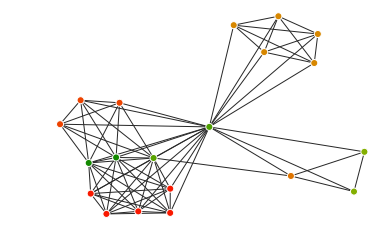

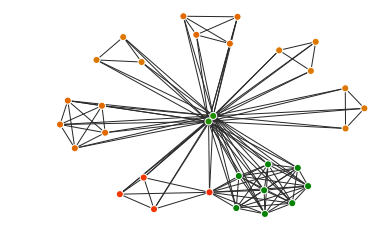

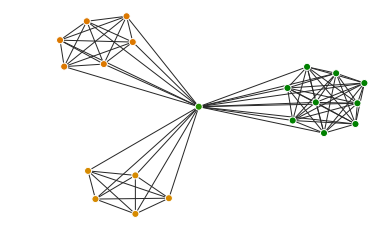

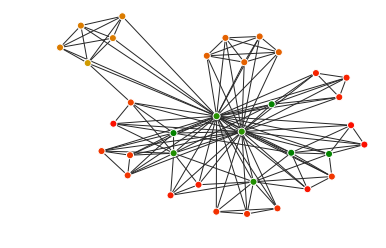

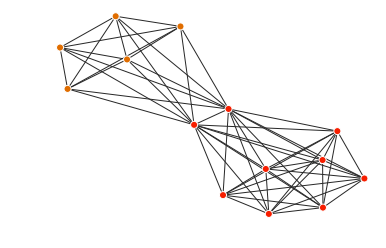

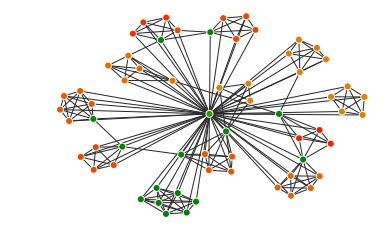

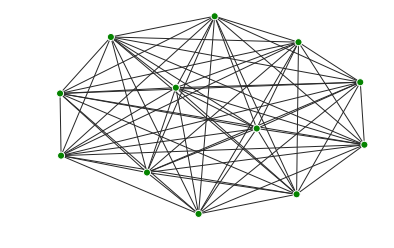

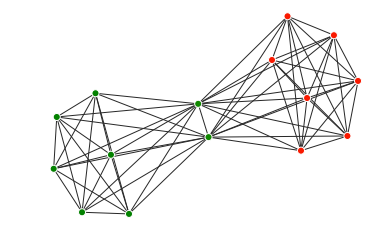

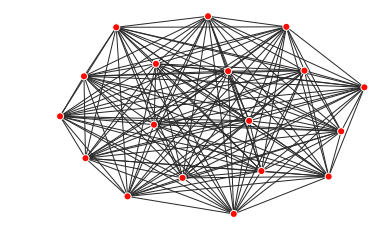

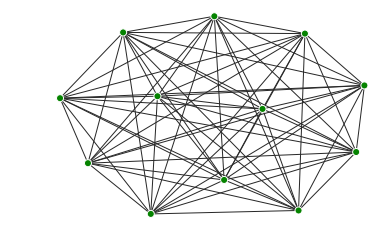

In [77]:
for i in range(10):
    pyt_geo_graph =  dataset[i]
    plot_graph(pyt_geo_graph, model)